### Loading modules

In [1]:
# General
import numpy as np
import pandas as pd
import math
from os.path import exists
from surge_tools import *

# ML
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Visualization / Interpretation
from time import gmtime
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

### Hyperparameters

In [2]:
pca_variance = 0.99
alpha = 0.0077

### Naming version

In [3]:
def name_of(v,s):
    return "y_test_"+str(v)+"_"+str(s)+".csv"

version = 4
subversion = 0
while True:
    if exists(name_of(version, subversion)):
        subversion += 1
    else:
        break

name = name_of(version, subversion)
print(name)

y_test_4_1.csv


### Loading and preparing train and test data

In [4]:
slp_tr = X_train['slp']
surge1_input_all = X_train['surge1_input']
surge2_input_all = X_train['surge2_input']
surge1_out_all = np.array(y_train)[:,1:11]
surge2_out_all = np.array(y_train)[:,11:21]
time1_input_all = np.array(X_train['t_surge1_input'])[:,-1:]
time2_input_all = np.array(X_train['t_surge2_input'])[:,-1:]
scaler1 = StandardScaler()
scaler1.fit(time1_input_all)
time1_input_all = scaler1.transform(time1_input_all)
scaler2 = StandardScaler()
scaler2.fit(time2_input_all)
time2_input_all = scaler2.transform(time2_input_all)

X_tr = np.array([np.ndarray.flatten(np.array(slp)) for slp in slp_tr])
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)

X1_tr = surge1_input_all
X2_tr = surge2_input_all
time1_input_tr = time1_input_all
time2_input_tr = time2_input_all

slp_tst = X_test['slp']

X_tst = scaler.transform(np.array([np.ndarray.flatten(np.array(slp)) for slp in slp_tst]))

X1_tst = X_test['surge1_input']
X2_tst = X_test['surge2_input']
time1_input_tst = scaler1.transform(np.array(X_test['t_surge1_input'])[:,-1:])
time2_input_tst = scaler2.transform(np.array(X_test['t_surge2_input'])[:,-1:])

y1_tr = surge1_out_all
y2_tr = surge2_out_all

y1_tr_norm = [normalize_l2_y(y_sample) for y_sample in y1_tr]
y2_tr_norm = [normalize_l2_y(y_sample) for y_sample in y2_tr]

### PCA reduction

In [5]:
print('Dimension Reduction...')
pca = PCA(n_components = pca_variance)
pca.fit(X_tr)
print('...done')
X_red_tr = pca.transform(X_tr)
X_red_tst = pca.transform(X_tst)
print(pca.explained_variance_ratio_)
print(len(pca.explained_variance_ratio_))

Dimension Reduction...
...done
[2.35355407e-01 1.79186746e-01 1.00124508e-01 5.24174385e-02
 5.14078066e-02 4.57058437e-02 3.91164050e-02 2.84490399e-02
 2.18870752e-02 1.86009165e-02 1.55188758e-02 1.44303711e-02
 1.31169679e-02 1.10917948e-02 1.00345062e-02 9.38487053e-03
 8.37524701e-03 8.26199260e-03 6.56731846e-03 5.83287422e-03
 5.27228741e-03 4.86356393e-03 4.55807336e-03 4.21864586e-03
 3.89739731e-03 3.54497787e-03 3.44369211e-03 3.35875107e-03
 3.04789725e-03 2.86207069e-03 2.74180924e-03 2.64165062e-03
 2.19578017e-03 2.15464341e-03 2.09486624e-03 2.04116455e-03
 1.97709026e-03 1.88209955e-03 1.81355351e-03 1.77294982e-03
 1.63190928e-03 1.58042915e-03 1.54832751e-03 1.51234376e-03
 1.48086122e-03 1.40553503e-03 1.34942762e-03 1.28023594e-03
 1.18387013e-03 1.14110333e-03 1.13372051e-03 1.09653594e-03
 1.05747732e-03 1.01426884e-03 9.71625617e-04 9.26367182e-04
 9.00801795e-04 8.66088318e-04 8.30789213e-04 8.10562633e-04
 7.91916624e-04 7.46971287e-04 7.32281827e-04 7.072933

### Lasso Regression

In [6]:
X_first_tr = np.array([np.concatenate((X_red_tr[i], X1_tr[i], time1_input_tr[i]))
                       for i in range(len(X_tr))])
X_first_tst = np.array([np.concatenate((X_red_tst[i], X1_tst[i], time1_input_tst[i]))
                       for i in range(len(X_tst))])

clf1 = Lasso(alpha=alpha)
print('Linear Regression 1...')
clf1.fit(X_first_tr, y1_tr_norm)
print('...done')

y1_pred_norm = clf1.predict(X_first_tst)
y1_pred = np.array([denormalize_l2_y(y_sample) for y_sample in y1_pred_norm])

Linear Regression 1...
...done


In [7]:
X_second_tr = np.array([np.concatenate((X_red_tr[i], X2_tr[i], time2_input_tr[i]))
                        for i in range(len(X_tr))])
X_second_tst = np.array([np.concatenate((X_red_tst[i], X2_tst[i], time2_input_tst[i]))
                        for i in range(len(X_tst))])

clf2 = Lasso(alpha=alpha)
print('Linear Regression 2...')
clf2.fit(X_second_tr, y2_tr_norm)
print('...done')

y2_pred_norm = clf2.predict(X_second_tst)
y2_pred = np.array([denormalize_l2_y(y_sample) for y_sample in y2_pred_norm])

Linear Regression 2...
...done


In [8]:
# Prediction on known data
y1_tr_pred_norm = clf1.predict(X_first_tr)
y1_tr_pred = np.array([denormalize_l2_y(y_sample) for y_sample in y1_tr_pred_norm])

y2_tr_pred_norm = clf2.predict(X_second_tr)
y2_tr_pred = np.array([denormalize_l2_y(y_sample) for y_sample in y2_tr_pred_norm])

### Export

In [9]:
y_pred = [np.concatenate((y1_pred[i],y2_pred[i])) for i in range(len(y1_pred))]
y_pred_DF = pd.DataFrame(data=y_pred, columns=surge_columns)

y_test = pd.DataFrame(data=y_pred, columns=surge_columns, index=X_test['id_sequence'])
if not(exists(name)):
    y_test.to_csv(name, index_label='id_sequence', sep=',')
else:
    print("File " + name + " already exists")

### Benchmark

In [10]:
slp_all = X_train['slp']
surge_all = np.array(y_train)[:,1:]

# Hyperparameters
k = 40
nfields = 2
time_step_slp = 8

length_one_slp = len(slp_all[0][0])*len(slp_all[0][0][0])

X_bench = []
for i in range(len(slp_all)):
    X_bench.append(np.ndarray.flatten(slp_all[i,-1]))
    for j in range(1,nfields):
        X_bench[-1] = np.concatenate( ( X_bench[-1], np.ndarray.flatten(slp_all[i,-1-j*time_step_slp]) ) )
X_bench = np.array(X_bench)
y_bench = surge_all

X_bench_tst = []
for i in range(len(slp_tst)):
    X_bench_tst.append(np.ndarray.flatten(slp_tst[i,-1]))
    for j in range(1,nfields):
        X_bench_tst[-1] = np.concatenate( ( X_bench_tst[-1], np.ndarray.flatten(slp_tst[i,-1-j*time_step_slp]) ) )
X_bench_tst = np.array(X_bench_tst)

# Fitting with KNN Regression
from sklearn.neighbors import KNeighborsRegressor

print('KNN...')
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_bench, y_bench)
print('done')

KNN...
done


In [11]:
y_bench_tr = neigh.predict(X_bench)
y1_bench_tr = y_bench_tr[:,:10]
y2_bench_tr = y_bench_tr[:,10:]

y_bench_tst = neigh.predict(X_bench_tst)
y1_bench_tst = y_bench_tst[:,:10]
y2_bench_tst = y_bench_tst[:,10:]

### Interpretation of the model

In [50]:
# Explanation of surges of first city
# First we add the normalization as the output is
def normalize_coeff(coeff):
    return [coeff[i]*weights_in_sqrt_inv[i] for i in range(len(coeff))]

coeff_global1 = normalize_coeff([sum(abs(clf1.coef_[i,:])) for i in range(10)])
time1 = normalize_coeff([clf1.coef_[i,-1] for i in range(10)])
surges1 = [[clf1.coef_[i,j] for i in range(10)] for j in range(-11,-1)]
# NO NORMALIZATION since input and output in normalized form
SLP1 = normalize_coeff([sum(abs(clf1.coef_[i,0:-11])) for i in range(10)])

# Influence of time
seconds_per_ten_years = 10*365*24*60*60
std1 = np.sqrt(scaler1.var_[0])
coeff1_per_ten_years = seconds_per_ten_years/std1

time2 = normalize_coeff([clf2.coef_[i,-1] for i in range(10)])
std2 = np.sqrt(scaler2.var_[0])
coeff2_per_ten_years = seconds_per_ten_years/std2

time1_10years = [coeff1_per_ten_years*c for c in time1] # Influence of time surge 1
time2_10years = [coeff2_per_ten_years*c for c in time2] # Influence of time surge 2

print(np.mean(time1_10years))
print(np.std(time1_10years))
print(np.mean(time2_10years))
print(np.std(time2_10years))
print(np.mean(abs(clf1.coef_[:,0:-11])))
print(np.std(abs(clf1.coef_[:,0:-11])))

0.06621175672057444
0.013490033573663573
0.052569134809279015
0.022335598547057148
0.0024940856
0.0029204295


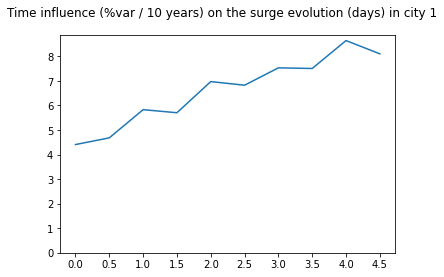

In [59]:
# Plot time curve
surge_time_range = [i/2 for i in range(10)]

fig, ax = plt.subplots()
fig.suptitle('Time influence (%var / 10 years) on the surge evolution (days) in city 1')
ax.plot(surge_time_range, 100*np.array(time1_10years))
ax.set_ylim(ymin = 0)
ax.set_xticks(surge_time_range)
plt.show()

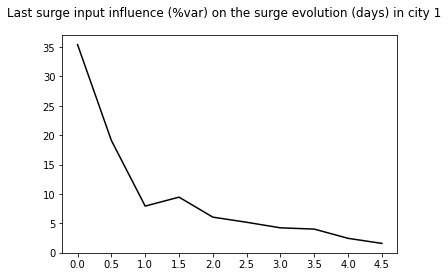

In [58]:
fig, ax = plt.subplots()
fig.suptitle('Last surge input influence (%var) on the surge evolution (days) in city 1')
ax.plot(surge_time_range, 100*np.array(surges1[-1]), color = 'black')
ax.set_ylim(ymin = 0, ymax = 37)
ax.set_xticks(surge_time_range)
plt.show()

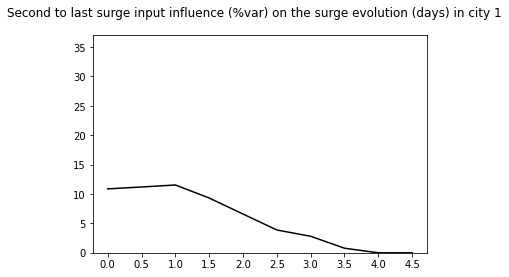

In [60]:
fig, ax = plt.subplots()
fig.suptitle('Second to last surge input influence (%var) on the surge evolution (days) in city 1')
ax.plot(surge_time_range, 100*np.array(surges1[-2]), color='black')
ax.set_ylim(ymin = 0, ymax = 37)
ax.set_xticks(surge_time_range)
plt.show()

In [26]:
# Convert time from int to date (year, month, hour)
def time_formatted(t):
    t_dt = datetime.datetime.fromtimestamp(t)
    return t_dt.strftime('%Y-%m-%d, %H:%M:%S')

time_formatted(X_train['t_surge1_input'][0][0])

'1950-01-01, 13:00:00'

### Visualization

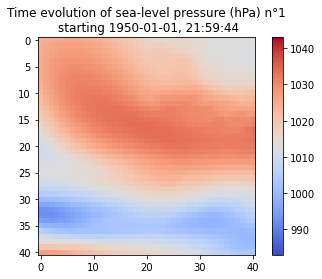

In [27]:
# SLPs
pressure_average = 1013
pressure_range = 30
vmin = pressure_average - pressure_range
vmax = pressure_average + pressure_range

def image_slp(id,time):
    slp_i = None
    L = len(slp_tr)
    date = ''
    if id <= L:
        slp_i = slp_tr[id-1]
        date = time_formatted(X_train['t_slp'][id-1][0])
    else:
        slp_i = slp_tst[id-1-L]
        date = time_formatted(X_test['t_slp'][id-1-L][0])
    slp_i = slp_i/100
    fig, ax = plt.subplots()
    ax.set_title('Time evolution of sea-level pressure (hPa) n°'+str(id)+'\n starting '+date)
    img = ax.imshow(slp_i[time], vmin=vmin, vmax=vmax, cmap=mpl.cm.coolwarm)
    plt.colorbar(img)
    plt.show(img)

image_slp(1,0)

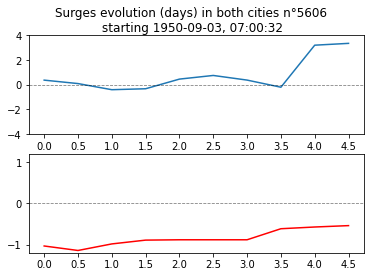

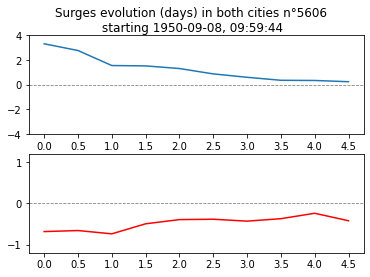

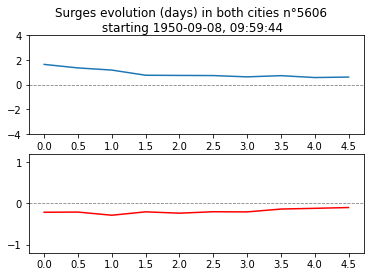

In [28]:
# Tide surges
surge_time_range = [i/2 for i in range(10)]
y1 = 4
y2 = 1.2
def plot_surges_pair(surge1, surge2, id, date):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Surges evolution (days) in both cities n°'+str(id)+'\n starting '+date)

    ax1.plot(surge_time_range, surge1)
    ax1.set_xticks(surge_time_range)

    ax2.plot(surge_time_range, surge2,'r')
    ax2.set_xticks(surge_time_range)
        
    ax1.axhline(y = 0, color = 'black', linewidth = 0.8, alpha = 0.5, ls = '--')
    yabs_max1 = abs(max(ax1.get_ylim(), key=abs))
    ax1.set_ylim(ymin=-y1, ymax=y1)
    
    ax2.axhline(y = 0, color = 'black', linewidth = 0.8, alpha = 0.5, ls = '--')
    yabs_max2 = abs(max(ax2.get_ylim(), key=abs))
    ax2.set_ylim(ymin=-y2, ymax=y2)
    

def plot_surges_input(id):
    L = len(slp_tr)
    if id <= L: 
        plot_surges_pair(X_train['surge1_input'][id-1], X_train['surge2_input'][id-1], id,
                         time_formatted(X_train['t_surge1_input'][id-1][0]))
    else:
        plot_surges_pair(X_test['surge1_input'][id-1-L], X_test['surge2_input'][id-1-L], id,
                         time_formatted(X_test['t_surge1_input'][id-1-L][0]))
    
def plot_surges_output(id):
    # Real outputs
    plot_surges_pair(surge1_out_all[id-1], surge2_out_all[id-1], id,
                         time_formatted(X_train['t_surge1_output'][id-1][0]))

def plot_surges_pred(id):
    L = len(slp_tr)
    if id <= L: 
        plot_surges_pair(y1_tr_pred[id-1], y2_tr_pred[id-1], id,
                         time_formatted(X_train['t_surge1_output'][id-1][0]))
    else:
        plot_surges_pair(y1_pred[id-1-L], y2_pred[id-1-L], id,
                         time_formatted(X_test['t_surge1_output'][id-1-L][0]))
        
def plot_surges_bench(id):
    L = len(slp_tr)
    if id <= L: 
        plot_surges_pair(y1_bench_tr[id-1], y2_bench_tr[id-1], id,
                         time_formatted(X_train['t_surge1_output'][id-1][0]))
    else:
        plot_surges_pair(y1_bench_tst[id-1-L], y2_bench_tst[id-1-L], id,
                         time_formatted(X_test['t_surge1_output'][id-1-L][0]))

ind = 5606
plot_surges_input(ind)
#plot_surges_output(ind)
plot_surges_pred(ind)
plot_surges_bench(ind)